# About this notebook

This notebook presents three different Deep Learning models for training Universal Bank dataset. These are the models which are taken:

- Feedforward Neural Network with k-Fold validation
- TabNet model with k-Fold validation
- Wide & Deep neural network architecture

Amongst this, TabNet model is selected which gives 0.985 validation accuracy.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/UniversalBank.csv')

# Dataset Description

#### Observations

1. Minimum value of Experience is -3 which is not possible.
2. ZIP Code is not a numeric data. It is to be considered as nominal data. Out of 5000 records, there are only 467 unique ZIP codes. Thus this represents that the dataset is restricted to a particular region.
3. Education has 3 unique values {1: Bachelor, 2: Masters, 3: Advanced Degree}. So this is again not a numeric data. It is ordinal data.
4. Personal Loan (Target Variable) is either 0 or 1. {0: Loan not approved, 1: Loan approved}. So this is binary data,
5. Securities Account is binary data representing {0: doesn't have security account, 1: has security account}
6. CD Account is binary data representing {0: doesn't have CD Account, 1: has CD Account}
7. Online is binary data representing {0: doesn't use online banking, 1: uses online banking}
8. Credit Card is binary data representing {0: doesn't have credit card, 1: has credit card}
9. ID is the unique column representing IDs of records.

Rest are numeric data

In [4]:
train.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


# Checking for negative values if any

It can be seen that Experience field has 52 negative values. But this field should always be zero or positive.

In [6]:
(train < 0).sum()

ID                     0
Age                    0
Experience            52
Income                 0
ZIP Code               0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal Loan          0
Securities Account     0
CD Account             0
Online                 0
CreditCard             0
dtype: int64

# Type Casting

1. Numeric to Boolean
2. Numeric to String

In [7]:
train['ZIP Code'].nunique() # Out of 5000 records, there are 467 unique values

467

In [8]:
train['CD Account'] = train['CD Account'].astype(bool)
train['Online'] = train['Online'].astype(bool)
train['CreditCard'] = train['CreditCard'].astype(bool)
train['Personal Loan'] = train['Personal Loan'].astype(bool)
train['ZIP Code'] = train['ZIP Code'].astype(str)
train['Education'] = train['Education'].astype(str)
train['Securities Account'] = train['Securities Account'].astype(bool)

# Checking the data where Experience is less than 0

It can be observed that other fields have valid records. So we can't drop these records. Instead we will replace it with appropriate values.

In [9]:
train[train['Experience']<0]

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.30,3,0,False,False,False,False,True
226,227,24,-1,39,94085,2,1.70,2,0,False,False,False,False,False
315,316,24,-2,51,90630,3,0.30,3,0,False,False,False,True,False
451,452,28,-2,48,94132,2,1.75,3,89,False,False,False,True,False
524,525,24,-1,75,93014,4,0.20,1,0,False,False,False,True,False
536,537,25,-1,43,92173,3,2.40,2,176,False,False,False,True,False
540,541,25,-1,109,94010,4,2.30,3,314,False,False,False,True,False
576,577,25,-1,48,92870,3,0.30,3,0,False,False,False,False,True
583,584,24,-1,38,95045,2,1.70,2,0,False,False,False,True,False
597,598,24,-2,125,92835,2,7.20,1,0,False,True,False,False,True


# Cheking the minimum difference between age and experience

So at age 23, people have no experience. So after 23, they can have n year experience.

In [10]:
n = 0
while True:
    m = (train['Age'] - train['Experience'] <= n).sum()
    if m > 0:
        break
    n += 1
print(n)

24


In [13]:
train.loc[train['Experience'] < 0, 'Experience'] = train.loc[train['Experience'] < 0, 'Age'] - 23

In [14]:
train.describe() # checkong the minimum and maximum Experience value

,ID,Age,Experience,Income,Family,CCAvg,Mortgage
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.135400,73.774200,2.396400,1.937938,56.498800
std,1443.520003,11.463166,11.414672,46.033729,1.147663,1.747659,101.713802
min,1.000000,23.000000,0.000000,8.000000,1.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,1.000000,0.700000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,2.000000,1.500000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,3.000000,2.500000,101.000000
max,5000.000000,67.000000,43.000000,224.000000,4.000000,10.000000,635.000000


# Data-preprocessing

This code performs data preprocessing tasks, particularly encoding categorical variables and frequency encoding one of the features.

#### Frequency Encoding for 'ZIP Code':

- Calculates the frequency of each unique value in the 'ZIP Code' column by dividing the count of each value by the total number of samples in the DataFrame.
- Maps these frequencies to the corresponding 'ZIP Code' values in the DataFrame, effectively encoding the 'ZIP Code' column with its frequency values.
- Saves the frequency encoding dictionary (zip_code_freq) using the joblib.dump() function to a file named 'zip_code_freq_encoder.pkl'.

#### Label Encoding for Categorical Columns:

- Specifies a list of columns (columns_to_encode) that need to be label encoded: 'Education', 'Personal Loan', 'CD Account', 'Online', 'CreditCard', and 'Securities Account'.
- Iterates over each column in columns_to_encode and applies label encoding using LabelEncoder() from scikit-learn.
- Saves the trained label encoders for each column in a dictionary (label_encoders) where the column name is the key and the corresponding label encoder is the value.
- Updates the DataFrame train by replacing the original categorical values with their encoded counterparts.

#### Saving Label Encoders:

- Saves the dictionary of label encoders (label_encoders) to a file named 'label_encoders.pkl' using the joblib.dump() function.

In [15]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Displaying the DataFrame structure
print("Original DataFrame:")
print(train.info())

# Frequency encoding for 'ZIP Code'
zip_code_freq = train['ZIP Code'].value_counts() / len(train)
train['ZIP Code'] = train['ZIP Code'].map(zip_code_freq)

# Saving the frequency encoding
joblib.dump(zip_code_freq, 'zip_code_freq_encoder.pkl')

# Columns to encode using LabelEncoder
columns_to_encode = ['Education', 'Personal Loan', 'CD Account', 'Online', 'CreditCard', 'Securities Account']

# Initialize a single label encoder dictionary to store the label encoders
label_encoders = {}

# Encoding the columns using a single LabelEncoder
for col in columns_to_encode:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Saving the single label encoder dictionary
joblib.dump(label_encoders, 'label_encoders.pkl')

# Displaying info of the updated DataFrame
print("\nUpdated DataFrame Info:")
print(train.info())

Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   object 
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   object 
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   bool   
 10  Securities Account  5000 non-null   bool   
 11  CD Account          5000 non-null   bool   
 12  Online              5000 non-null   bool   
 13  CreditCard          5000 non-null   bool   
dtypes: bool(5), float64(1), int64(6), object(2)
memory usage: 376.1+ KB
None

Updated Da

# Correlation Matrix

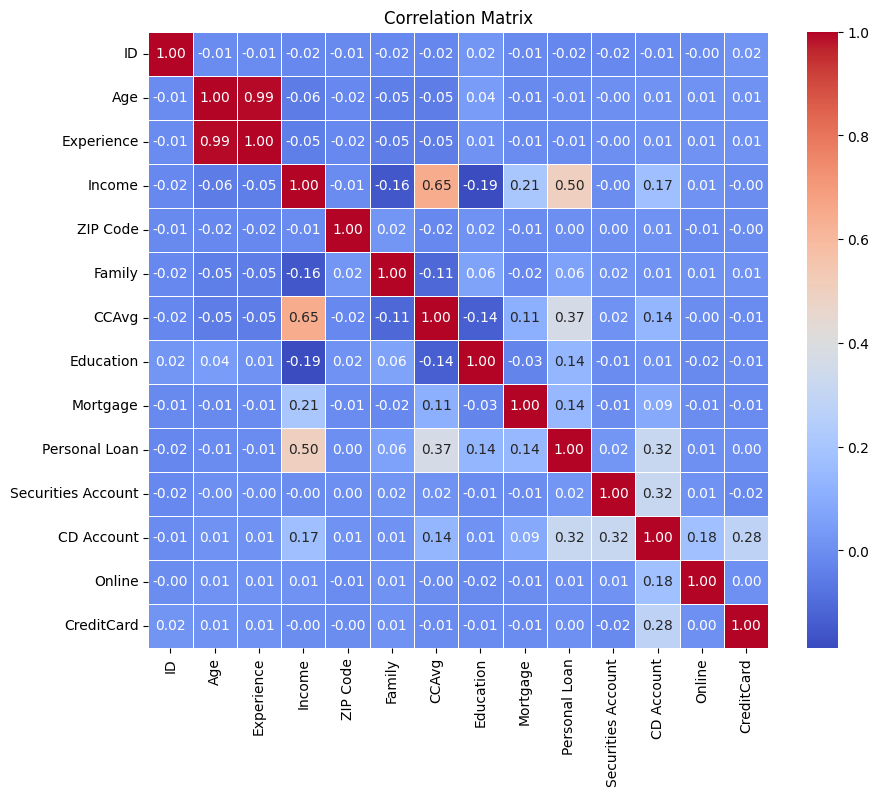

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = train.corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Data Visualization

#### Histogram of Age
- This plot shows the distribution of ages in the dataset.
- The histogram is stacked by the 'Personal Loan' variable, allowing us to see the distribution of ages for those who got and those who did not get personal loans.
- It helps visualize if there are any differences in age distribution between those who got personal loans and those who did not.

#### Boxplot of Income
- This plot displays the distribution of income for each category of 'Personal Loan'.
- The boxplot provides information about the median, quartiles, and potential outliers in income for each group.
- It helps us to identify if there are significant differences in income between those who got personal loans and those who did not.

#### Barplot of Education
- This plot shows the count of individuals in each category of education, separated by the 'Personal Loan' variable.
- It helps visualize the distribution of education levels among those who got personal loans and those who did not.
- Differences in the proportions of education levels between the two groups can be observed.

#### Violin Plot of CCAvg
- This plot displays the distribution of average credit card spending (CCAvg) for each category of 'Personal Loan'.
- It combines the features of a box plot and a kernel density plot, showing both summary statistics and the probability density of the data at different values.
- It helps compare the distribution of CCAvg between individuals who got personal loans and those who did not.

#### Boxen Plot of Mortgage
- This plot shows the distribution of mortgage amounts for each category of 'Personal Loan'.
- Similar to a box plot, it displays information about the median, quartiles, and potential outliers in mortgage amounts for each group.
- It helps identify any differences in mortgage amounts between individuals who got personal loans and those who did not.

#### Swarm Plot of Experience
- This plot displays the distribution of work experience (in years) for each category of 'Personal Loan'.
- It shows individual data points along the categorical axis, providing a clearer picture of the distribution compared to a traditional scatter plot.
- It helps visualize if there are any patterns or differences in work experience between individuals who got personal loans and those who did not.

These plots collectively provide insights into how different variables relate to the likelihood of individuals accepting personal loans.

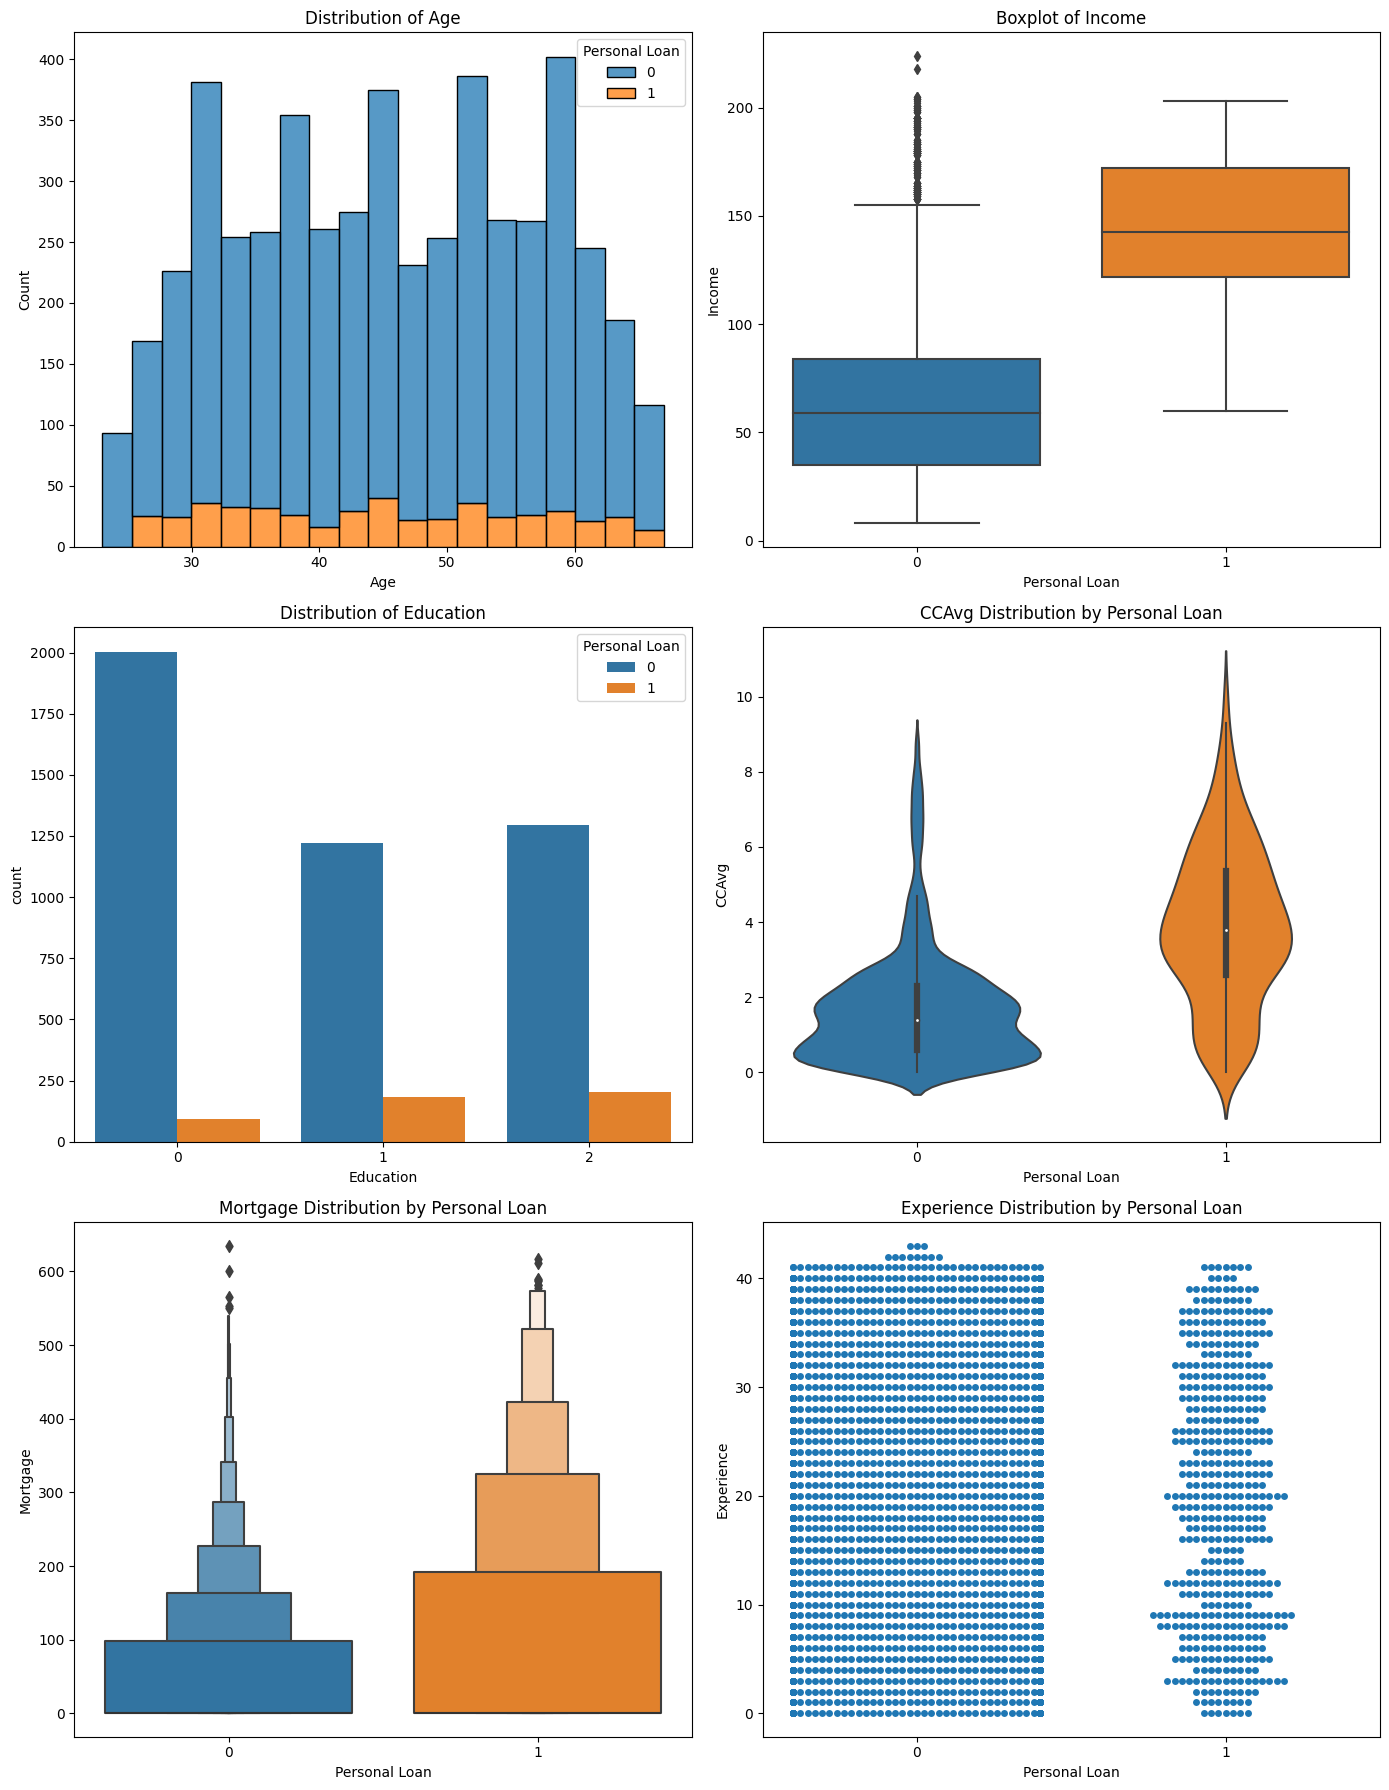

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Plot 1: Histogram of Age
sns.histplot(data=train, x='Age', hue='Personal Loan', multiple='stack', ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Age')

# Plot 2: Boxplot of Income
sns.boxplot(data=train, y='Income', x='Personal Loan', ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Income')

# Plot 3: Barplot of Education
sns.countplot(data=train, x='Education', hue='Personal Loan', ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Education')

# Plot 4: Violin Plot of CCAvg
sns.violinplot(data=train, x='Personal Loan', y='CCAvg', ax=axs[1, 1])
axs[1, 1].set_title('CCAvg Distribution by Personal Loan')

# Plot 5: Boxen Plot of Mortgage
sns.boxenplot(data=train, x='Personal Loan', y='Mortgage', ax=axs[2, 0])
axs[2, 0].set_title('Mortgage Distribution by Personal Loan')

# Plot 6: Swarm Plot of Experience
sns.swarmplot(data=train, x='Personal Loan', y='Experience', ax=axs[2, 1])
axs[2, 1].set_title('Experience Distribution by Personal Loan')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
X = train.drop(['ID', 'Personal Loan'], axis=1)  # Features
y = train['Personal Loan']  # Target

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# converting to numpy arrays

X = X.to_numpy()
y = y.to_numpy()

In [19]:
# import necessary modules
from pytorch_tabnet.tab_model import TabNetClassifier
 
import os
import torch
 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Feedforward Neural Network

A Feedforward Neural Network (FNN) is a type of artificial neural network where connections between the nodes do not form a cycle. It is the simplest form of neural networks where the information moves in only one direction—forward—from the input nodes, through the hidden nodes (if any), and to the output nodes. There are no loops or cycles in the network.

#### Key Components:
- Input Layer: This layer receives the input data.
- Hidden Layers: Intermediate layers where computations are performed. These layers apply transformations to the input data and pass it to the next layer.
- Output Layer: Produces the final output of the network. For binary classification, a single neuron with a sigmoid activation function is typically used.
- Activation Functions: Non-linear functions applied to each layer's output to introduce non-linearity into the network, allowing it to learn complex patterns.

Here we implement a feedforward neural network for binary classification using TensorFlow and Keras. It uses K-Fold Cross-Validation to evaluate the model's performance, ensuring that the results are robust and generalize well to unseen data. Each fold involves training a new model and applying early stopping to prevent overfitting, with the best epoch's weights restored for evaluation.

#### Layers:
- The first dense layer has 64 neurons and uses the ReLU activation function.
- The second dense layer has 32 neurons and also uses the ReLU activation function.
- The output layer has 1 neuron and uses the sigmoid activation function to output a probability for binary classification.

#### Compilation:
- The loss function is binary_crossentropy, suitable for binary classification.
- The optimizer is adam, an adaptive learning rate optimizer.
- The metric is accuracy.

#### K-Fold Cross-Validation:
- The dataset is split into 5 parts (folds).

<br><br>

<table style="text-align: center; width: 80%; font-size: 16px; border-collapse: collapse;">
    <caption>Accuracies over all folds</caption>
    <tr>
        <th style="border: 1px solid black;"> </th>
        <th style="border: 1px solid black;">Fold 1</th>
        <th style="border: 1px solid black;">Fold 2</th>
        <th style="border: 1px solid black;">Fold 3</th>
        <th style="border: 1px solid black;">Fold 4</th>
        <th style="border: 1px solid black;">Fold 5</th>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Best Epoch</th>
        <td style="border: 1px solid black;">47</td>
        <td style="border: 1px solid black;">45</td>
        <td style="border: 1px solid black;">25</td>
        <td style="border: 1px solid black;">47</td>
        <td style="border: 1px solid black;">45</td>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Final Validation Loss</th>
        <td style="border: 1px solid black;">0.1204</td>
        <td style="border: 1px solid black;">0.0833</td>
        <td style="border: 1px solid black;">0.1053</td>
        <td style="border: 1px solid black;">0.1113</td>
        <td style="border: 1px solid black;">0.0882</td>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Final Validation Accuracy</th>
        <td style="border: 1px solid black;">0.9549</td>
        <td style="border: 1px solid black;">0.9620</td>
        <td style="border: 1px solid black;">0.9660</td>
        <td style="border: 1px solid black;">0.9679</td>
        <td style="border: 1px solid black;">0.9710</td>
    </tr>
</table>



<br>
Overall Average Validation Loss: 0.10173177272081375 <br>
Overall Average Validation Accuracy: 0.9644000053405761

In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Feedforward Neural Network model architecture

def create_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# K-Fold parameters
n_splits = 5
random_state = 42

# KFold object
kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

# Lists to store results
CV_loss_history = []
CV_accuracy_history = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    # Spliting data into training and validation sets
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

    # Creating a new FNN model for each fold
    model = create_model()

    # Early stopping callback to track best epoch for validation accuracy
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

    # Training the model with early stopping
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

    # Getting final validation loss and accuracy
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]

    # Printing results, including best epoch from EarlyStopping callback
    print(f"Fold: {fold_index+1}")
    print(f"Best Epoch (Validation Accuracy): {early_stopping.best_epoch}")
    print(f"Final Validation Loss: {val_loss}")
    print(f"Final Validation Accuracy: {val_acc}")

    # Storing results
    CV_loss_history.append(val_loss)
    CV_accuracy_history.append(val_acc)

# Printing K-Fold evaluation results (average loss, accuracy)
print(f"\nOverall Average Validation Loss: {np.mean(CV_loss_history)}")
print(f"Overall Average Validation Accuracy: {np.mean(CV_accuracy_history)}")

2024-05-22 12:18:32.657193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 12:18:32.657356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 12:18:32.825289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7604 - loss: 2.0709 - val_accuracy: 0.8840 - val_loss: 0.2505
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8849 - loss: 0.2689 - val_accuracy: 0.8920 - val_loss: 0.2284
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.2360 - val_accuracy: 0.8850 - val_loss: 0.2547
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2424 - val_accuracy: 0.9230 - val_loss: 0.1737
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.2145 - val_accuracy: 0.8950 - val_loss: 0.2883
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9202 - loss: 0.2049 - val_accuracy: 0.9140 - val_loss: 0.1784
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.2213 - val_accuracy: 0.8990 - val_loss: 0.2929
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.2290 - val_accuracy: 0.

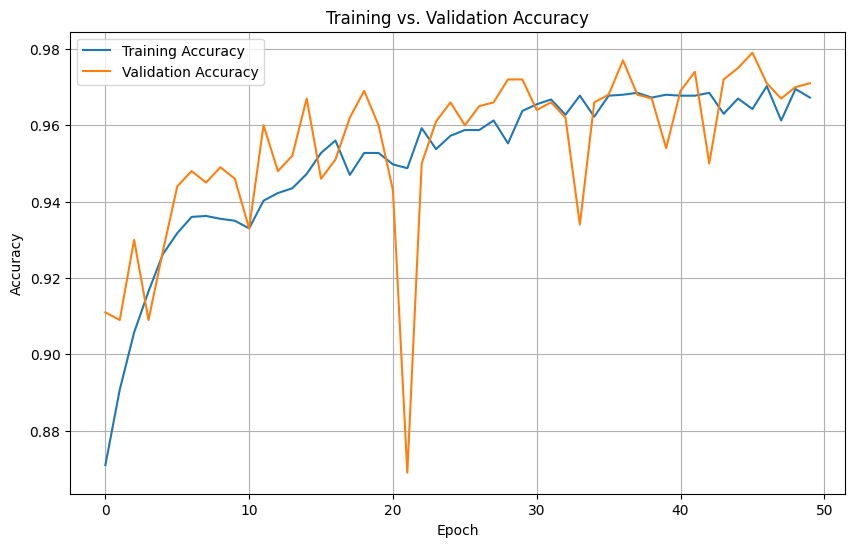

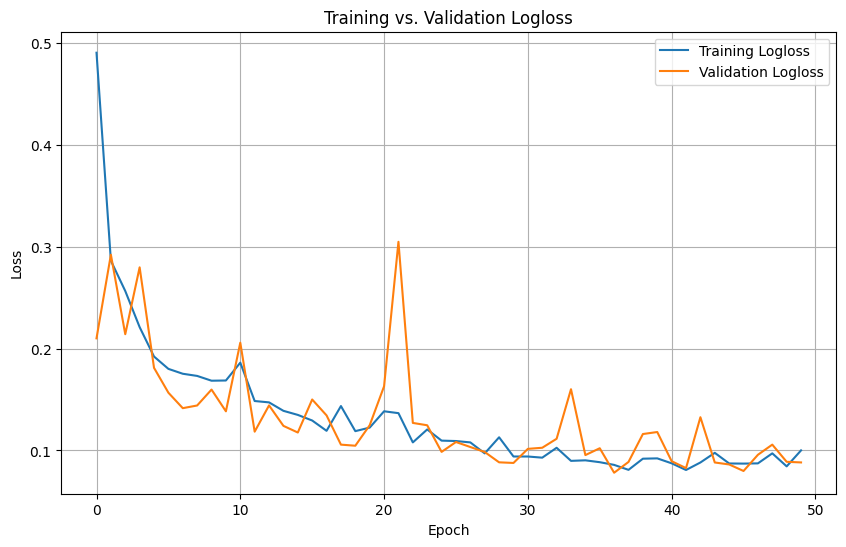

In [22]:
import matplotlib.pyplot as plt

# Assuming history is accessible from tb_cls.fit output
history = history.history  # Replace with appropriate method to access history

# Extract accuracy and loss for training and validation sets
train_acc = history['accuracy']  # Replace with actual metric names
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Logloss')
plt.plot(val_loss, label='Validation Logloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Logloss')
plt.legend()
plt.grid(True)
plt.show()

# TabNet Model

TabNet (Tabular Neural Network) is a neural network architecture designed specifically for tabular data, commonly encountered in structured data sets. It was introduced in the paper "TabNet: Attentive Interpretable Tabular Learning" by Sercan O. Arik and Tomas Pfister. TabNet is an interpretable and efficient neural network architecture that combines elements of deep learning with attention mechanisms and feature selection techniques. It aims to achieve state-of-the-art performance on tabular data while providing insights into feature importance and model decisions.

#### Architecture:

The architecture of TabNet consists of several key components:

- Feature Embedding Layer: Converts categorical variables into dense representations suitable for neural networks. This layer often utilizes techniques like embedding layers or one-hot encoding followed by dense layers.
- Feature Transformation Blocks: These blocks contain multiple sequential attention-based feature transformation steps. Each step performs feature selection and transformation using the features' interactions and dependencies.
- Decision Steps: In each feature transformation block, decision steps apply feature-wise gating mechanisms to select relevant features and suppress irrelevant ones based on their importance.
- Final Prediction Layer: The output of the feature transformation blocks is passed through a final prediction layer, typically consisting of fully connected layers followed by softmax or sigmoid activation functions for classification or regression tasks, respectively.

#### Training Process:

The training process involves optimizing the model parameters to minimize a defined loss function (e.g., cross-entropy loss for classification tasks). TabNet employs optimization techniques such as the Adam optimizer and learning rate scheduling to efficiently update the model parameters during training.


<br><br>

<table style="text-align: center; width: 80%; font-size: 16px; border-collapse: collapse;">
    <caption>Accuracies over all folds</caption>
    <tr>
        <th style="border: 1px solid black;"> </th>
        <th style="border: 1px solid black;">Fold 1</th>
        <th style="border: 1px solid black;">Fold 2</th>
        <th style="border: 1px solid black;">Fold 3</th>
        <th style="border: 1px solid black;">Fold 4</th>
        <th style="border: 1px solid black;">Fold 5</th>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Best Epoch</th>
        <td style="border: 1px solid black;">35</td>
        <td style="border: 1px solid black;">45</td>
        <td style="border: 1px solid black;">46</td>
        <td style="border: 1px solid black;">41</td>
        <td style="border: 1px solid black;">24</td>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Final Validation LogLoss</th>
        <td style="border: 1px solid black;">0.0438</td>
        <td style="border: 1px solid black;">0.0623</td>
        <td style="border: 1px solid black;">0.0626</td>
        <td style="border: 1px solid black;">0.0466</td>
        <td style="border: 1px solid black;">0.0651</td>
    </tr>
    <tr>
        <th style="border: 1px solid black;">Final Validation Accuracy</th>
        <td style="border: 1px solid black;">0.980</td>
        <td style="border: 1px solid black;">0.985</td>
        <td style="border: 1px solid black;">0.978</td>
        <td style="border: 1px solid black;">0.972</td>
        <td style="border: 1px solid black;">0.982</td>
    </tr>
</table>

In [31]:
y = y.flatten()

kf = KFold(n_splits=5, random_state=42, shuffle=True)
CV_score_array = []
for train_index, test_index in kf.split(X):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    tb_cls = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-3),
                       scheduler_params={"step_size":10, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                       )
    history = tb_cls.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_name=['train', 'valid'],
                    eval_metric=['accuracy', 'logloss'],
                    max_epochs=50, patience=25,
                    batch_size=28, drop_last=False)         
    CV_score_array.append(tb_cls.best_cost)

print(CV_score_array)

epoch 0  | loss: 0.42207 | train_accuracy: 0.907   | train_logloss: 0.33201 | valid_accuracy: 0.896   | valid_logloss: 0.35855 |  0:00:04s
epoch 1  | loss: 0.30114 | train_accuracy: 0.909   | train_logloss: 0.25234 | valid_accuracy: 0.904   | valid_logloss: 0.25999 |  0:00:08s
epoch 2  | loss: 0.25561 | train_accuracy: 0.91925 | train_logloss: 0.21899 | valid_accuracy: 0.91    | valid_logloss: 0.21791 |  0:00:13s
epoch 3  | loss: 0.22671 | train_accuracy: 0.9295  | train_logloss: 0.1824  | valid_accuracy: 0.918   | valid_logloss: 0.19067 |  0:00:17s
epoch 4  | loss: 0.19331 | train_accuracy: 0.944   | train_logloss: 0.15418 | valid_accuracy: 0.941   | valid_logloss: 0.16627 |  0:00:21s
epoch 5  | loss: 0.16893 | train_accuracy: 0.95225 | train_logloss: 0.1341  | valid_accuracy: 0.955   | valid_logloss: 0.13194 |  0:00:25s
epoch 6  | loss: 0.14958 | train_accuracy: 0.957   | train_logloss: 0.1205  | valid_accuracy: 0.963   | valid_logloss: 0.11347 |  0:00:30s
epoch 7  | loss: 0.14176 | 

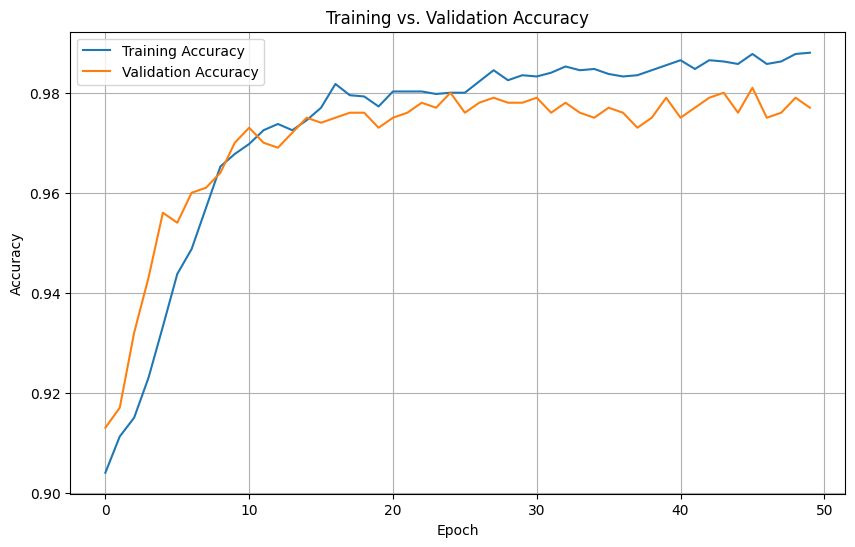

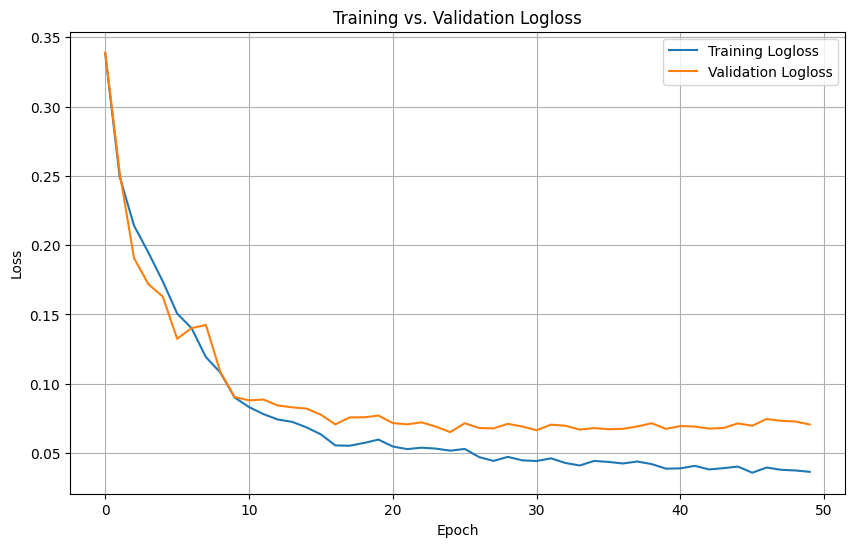

In [32]:
import matplotlib.pyplot as plt

# history accessible from tb_cls.fit output
history = tb_cls.history 

# Extract accuracy and loss for training and validation sets
train_acc = history['train_accuracy']
val_acc = history['valid_accuracy']
train_loss = history['train_logloss']
val_loss = history['valid_logloss']

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Logloss')
plt.plot(val_loss, label='Validation Logloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Logloss')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# saving model
tb_cls.save_model('/kaggle/working/best_model')

Successfully saved model at /kaggle/working/best_model.zip


'/kaggle/working/best_model.zip'

# Wide & Deep neural network architecture

This implements a Wide & Deep neural network architecture using TensorFlow's Keras API for binary classification tasks.

### Components of the Model:

#### Normalization of Data:

- The input data is normalized using mean and standard deviation calculated from the training data. This step helps in stabilizing the training process and improving convergence.

#### Wide Component:

- The wide component is a linear model that directly connects the input features to the output layer without any non-linear transformations. It is represented by a single Dense layer.

#### Deep Component:

- The deep component is a neural network consisting of multiple layers. Each layer is followed by Batch Normalization, LeakyReLU activation, and Dropout for regularization.
- It comprises three Dense layers with 128, 64, and 32 units, respectively.

#### Combining Wide and Deep Components:

- The outputs from the wide and deep components are concatenated using the Concatenate layer.
- This allows the model to learn both low-level and high-level feature representations simultaneously.

#### Final Output Layer:

- The concatenated output is passed through a final Dense layer with a sigmoid activation function, which outputs the predicted probability of the positive class (binary classification).

# Metrics

- Training Accuracy: 0.9715
- Training Loss: 0.0752
- val_accuracy: 0.9760
- val_loss: 0.0531 
- learning_rate: 1.0000e-05

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7249 - loss: 0.5691 - val_accuracy: 0.9360 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9137 - loss: 0.2822 - val_accuracy: 0.9670 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9409 - loss: 0.1778 - val_accuracy: 0.9670 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9478 - loss: 0.1414 - val_accuracy: 0.9720 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1274 - val_accuracy: 0.9710 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9462 - loss: 0.1290 - val_accuracy: 0.9690 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9552 - loss: 0.1181 - 

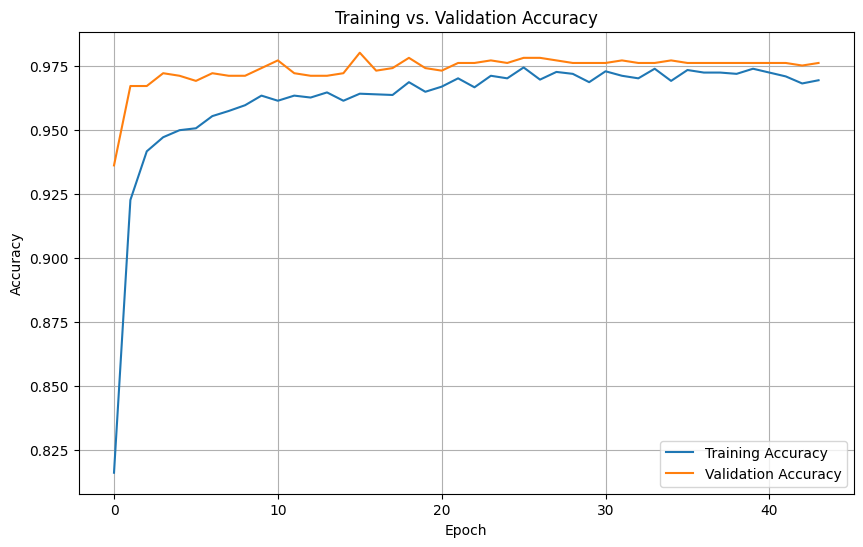

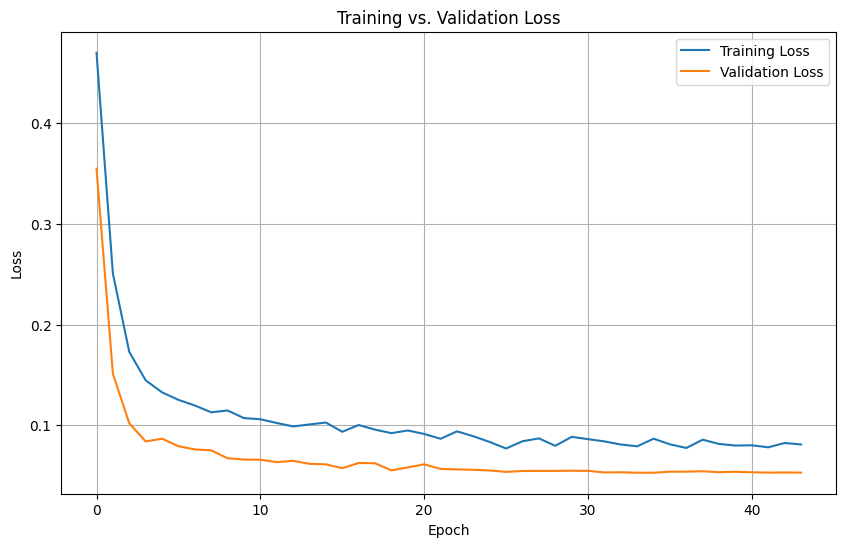

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Normalize the data
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

# Define input layers
inputs = Input(shape=(12,))

# Wide component (linear model)
wide_output = Dense(1)(inputs)

# Deep component (neural network)
deep_layer1 = Dense(128)(inputs)
deep_layer1 = BatchNormalization()(deep_layer1)
deep_layer1 = LeakyReLU()(deep_layer1)
deep_layer1 = Dropout(0.3)(deep_layer1)

deep_layer2 = Dense(64)(deep_layer1)
deep_layer2 = BatchNormalization()(deep_layer2)
deep_layer2 = LeakyReLU()(deep_layer2)
deep_layer2 = Dropout(0.3)(deep_layer2)

deep_layer3 = Dense(32)(deep_layer2)
deep_layer3 = BatchNormalization()(deep_layer3)
deep_layer3 = LeakyReLU()(deep_layer3)
deep_layer3 = Dropout(0.3)(deep_layer3)

deep_output = Dense(1)(deep_layer3)

# Combine wide and deep components
combined = Concatenate()([wide_output, deep_output])

# Final output layer
final_output = Dense(1, activation='sigmoid')(combined)

# Define model
model_wd = Model(inputs=inputs, outputs=final_output)

# Compile model with a lower learning rate and class weighting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_wd.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train model
history = model_wd.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the training history
import matplotlib.pyplot as plt

# Extract the history dictionary
history_dict = history.history

# Extract accuracy and loss for training and validation sets
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# How prediction can be made using trained TabNet model

In [38]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier

# Load the frequency encoding for 'ZIP Code'
zip_code_freq = joblib.load('/kaggle/working/zip_code_freq_encoder.pkl')

# Load the label encoders
label_encoders = joblib.load('/kaggle/working/label_encoders.pkl')

tb_cls = TabNetClassifier()
tb_cls.load_model('/kaggle/working/best_model.zip')

new_data = {
    'Age': [25],
    'Experience': [1],
    'Income': [49],
    'ZIP Code': ['91107'],
    'Family': [4],
    'CCAvg': [1.60],
    'Education': ['1'],
    'Mortgage': [0],
    'Securities Account': [False],
    'CD Account': [False],
    'Online': [True],
    'CreditCard': [False]
}

# Convert new_data to DataFrame
new_data = pd.DataFrame(new_data)

# Display the structure of new_data
print("New DataFrame:")
print(new_data.info())

# Apply the same frequency encoding to 'ZIP Code'
new_data['ZIP Code'] = new_data['ZIP Code'].map(zip_code_freq)

# Apply the same label encoding to other columns
columns_to_encode = ['Education', 'CD Account', 'Online', 'CreditCard', 'Securities Account']
for col in columns_to_encode:
    le = label_encoders[col]
    new_data[col] = le.transform(new_data[col])

# Convert the DataFrame to numpy array if necessary
new_data_np = new_data.to_numpy()

# Make predictions using the loaded model
predictions = tb_cls.predict(new_data_np)

# If you need probabilities instead of class labels
probabilities = tb_cls.predict_proba(new_data_np)

print("Predictions:")
print(predictions)

print("Probabilities:")
print(probabilities)

New DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1 non-null      int64  
 1   Experience          1 non-null      int64  
 2   Income              1 non-null      int64  
 3   ZIP Code            1 non-null      object 
 4   Family              1 non-null      int64  
 5   CCAvg               1 non-null      float64
 6   Education           1 non-null      object 
 7   Mortgage            1 non-null      int64  
 8   Securities Account  1 non-null      bool   
 9   CD Account          1 non-null      bool   
 10  Online              1 non-null      bool   
 11  CreditCard          1 non-null      bool   
dtypes: bool(4), float64(1), int64(5), object(2)
memory usage: 196.0+ bytes
None
Predictions:
[0]
Probabilities:
[[0.99735236 0.00264766]]
